# Figure 7. Global effect of SRSF3
---

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2021-01-21.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
utilpath = '/casa/bsc/notebooks/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
from __future__ import division
import sys; sys.path.append(utilpath)
from util import *
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/210121/


In [4]:
import pandas as pd
import numpy as np
import re
from scipy import stats as st
from matplotlib import pyplot as plt
from matplotlib import lines, gridspec, colors
from collections import defaultdict, Counter
from scipy.stats import sem, ttest_ind, mannwhitneyu, spearmanr, pearsonr
from scipy import stats as st
from sequtil import nmer
import seaborn as sns
%matplotlib inline

In [5]:
LIBRARIES = [ 'set1', 'set2', 'set3', 'set4', 'set5' ]

In [6]:
s1 = pd.read_csv('supplementary/TableS1__Previously_identified_DROSHA-dependence.csv', 
                 header=1, index_col=0)
s2 = pd.read_csv('supplementary/TableS2__Oligonucleotides_used_in_this_study.csv', 
                 header=1, index_col=0).fillna('')
s3 = pd.read_csv('supplementary/TableS3__In_vitro_processing_results_Microprocessor-only.csv',
                 header=1, index_col=0)
s4 = pd.read_csv('supplementary/TableS4__Cis-acting_elements_of_human_pri-miRNAs.csv', 
                 header=1, index_col=0)
s5 = pd.read_csv('supplementary/TableS5__In_vitro_processing_results_SRSF3.csv', 
                 header=1, index_col=0)

In [7]:
preposition = {}
for mir in s2.index:
    flank5, flank3 = s2.loc[mir,["5' flanking segment","3' flanking segment"]]
    if flank5 or flank3:
        preposition[mir] = (len(flank5)+1,125-len(flank3))
    else:
        preposition[mir] = (0,126)
print len(preposition), preposition['hsa-mir-142']

1881 (32, 90)


In [8]:
drodep = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-dependent')>=0)].index
droind = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-independent')>=0)].index
dbmirs = s1[s1['MirGeneDB']=='Annotated'].index
print len(drodep), len(droind), len(dbmirs)

311 257 503


In [9]:
constseqs = dict(s2['Construct sequence (125 nt)'])
print len(constseqs)

1881


In [10]:
EFFCUT = 1.5
HOMCUT = .25
effsmp = s3['Cleavage Efficiency'].to_dict()
homsmp = s3['Cleavage Homogeneity'].to_dict()
dcsmirsmp = [ m for m in s3.index if effsmp[m]>=EFFCUT and homsmp[m]>=HOMCUT ]
nodcsmp = [ m for m in s3.index if m not in dcsmirsmp ]
print len(s3.index), len(dcsmirsmp), len(nodcsmp)

1816 560 1256


In [11]:
effs = s5['Cleavage Efficiency'].to_dict()
homs = s5['Cleavage Homogeneity'].to_dict()
dcsmirs = [ m for m in s5.index if effs[m]>=EFFCUT and homs[m]>=HOMCUT ]
nodcs = [ m for m in s5.index if m not in dcsmirs ]
print len(s5.index), len(dcsmirs), len(nodcs)

1812 747 1065


In [15]:
majorcsmp = {}
for mir in dcsmirsmp:
    c5, c3 = s3.loc[[mir],["5' cleavage site","3' cleavage site"]].iloc[0]
    majorcsmp[mir] = (int(c5),int(c3))
print len(majorcsmp), majorcsmp['hsa-let-7a-1']

560 (25, 96)


In [16]:
majorcs = {}
for mir in dcsmirs:
    c5, c3 = s5.loc[[mir],["5' cleavage site","3' cleavage site"]].iloc[0]
    majorcs[mir] = (int(c5),int(c3))
print len(majorcs), majorcs['hsa-let-7a-1']

747 (25, 96)


---

## A. Global change induced by SRSF3

In [12]:
def get_2d_density(data, xmin, xmax, ymin, ymax):
    x, y = zip(*data)
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    return xx, yy, f

In [13]:
overlap = [ m for m in effs if m in effsmp ]
data1 = [ (effsmp[m],homsmp[m]) for m in overlap ]
data2 = [ (effs[m],homs[m]) for m in overlap ]
xmin, xmax = -2, 10
ymin, ymax = -.25, 1.1
xs1,ys1,f1 = get_2d_density(data1, xmin, xmax, ymin, ymax)
xs2,ys2,f2 = get_2d_density(data2, xmin, xmax, ymin, ymax)
blk = custom_cmap(['white','black'])
red = custom_cmap(['white','#de2d26'])
print len(overlap)

1800


Text(5.6,0.12,u'N = 1800')

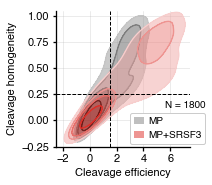

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(2.4,2.5))
ax.contourf(xs1,ys1,f1,levels=[.05,.15,.3,1,4],cmap=blk,alpha=.5,
            norm=colors.LogNorm(vmin=0.02, vmax=1),zorder=3)
ax.contour(xs1,ys1,f1,levels=[.05,.15,.3,1,4],cmap=blk,linestyles='-',linewidths=1.3,
          norm=colors.LogNorm(vmin=0.02, vmax=1),zorder=3)
ax.contourf(xs2,ys2,f2,levels=[.05,.15,.3,1,4],cmap=red,alpha=.5,
            norm=colors.LogNorm(vmin=0.02, vmax=1),zorder=3)
ax.contour(xs2,ys2,f2,levels=[.05,.15,.3,1,4],cmap=red,linestyles='-',linewidths=1.3,
          norm=colors.LogNorm(vmin=0.02, vmax=1), zorder=3)
ax.axhline(.25,color='k',ls='--',lw=1,zorder=3)
ax.axvline(1.5,color='k',ls='--',lw=1,zorder=3)

ax.set_xticks(np.arange(-2,8,2))
ax.set_yticks(np.arange(-.25,1.1,.25))
ax.set_xlim(-2.5,7.5)
ax.set_ylim(-.25,1.05)
ax.set_xlabel('Cleavage efficiency', fontsize=11)
ax.set_ylabel('Cleavage homogeneity', fontsize=11)
ax.bar([-10],[0],color='grey',label='MP',alpha=.5)
ax.bar([-10],[0],color='#de2d26',label='MP+SRSF3',alpha=.5)
ax.grid(ls='-',lw=.5)
ax.legend(loc=(.55,.02),handlelength=1,framealpha=1,handletextpad=.4)
ax.text(5.6,.12,'N = %s'%len(overlap))
#fig.savefig(resultpath+'210112_f7a__global_change.pdf',dpi=300)

## B. SRSF3-dependent miRNAs

In [17]:
mirls = [ [m for m in overlap if m in dcsmirsmp],
          [m for m in overlap if m not in dcsmirsmp and m in dcsmirs],
          [m for m in overlap if m in nodcs and m in nodcsmp] ]
data = map(len,mirls)
print data, np.array(data)/sum(data)
colors = '#5291bd #78c679 #bcbcbc'.split()

[557, 201, 1042] [0.30944444 0.11166667 0.57888889]


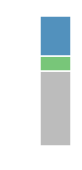

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(.6,2.5))
bottom = 0
for ml,c in zip(mirls,colors)[::-1]:
    ax.bar([0],[len(ml)],bottom=bottom,color=c,edgecolor='w',lw=1.5)
    bottom+=len(ml)
ax.axis('off')
fig.savefig(resultpath + '210112_f7b__fraction_drodep.pdf')

## C-D. Conservation and expression

In [18]:
def get_phylop_scores(chrom, start, end):
    phystarts = [ int(f.split('.')[0]) for f in listdir('%s/phyloP100way/%s'%(supplpath, chrom)) 
                  if f.endswith('.gz') ]
    init = sorted([ s for s in phystarts if s<=start ])[-1]
    if start<max(phystarts):
        nextst = sorted([ s for s in phystarts if s>start])[0]
    else: nextst = end
    rels, rele = start-init, end-init
    phys = open('supplementary/phyloP100way/%s/%s.phylop.gz'%(chrom,init),
                'rt').read().strip().split('\n')
    if len(phys) <= rels:
        if nextst >= end:
            return ['-']*(end-start+1)
        else:
            return ['-']*(nextst-start) + get_phylop_scores(chrom, nextst, end)
    elif len(phys) > rele:
        return map(float, phys[rels:rele+1])
    else: # rels < len(phys) <= rele
        return map(float, phys[rels:]) + get_phylop_scores(chrom, init+len(phys), end)

In [19]:
def get_mature_conserv(pri):
    mats = primat[pri]
    matcons = []
    for mat in mats:
        ch, st, en = annmat.loc[mat,['chr','start','end']]
        cons = [ c for c in get_phylop_scores(ch, st, en) if c!='-' ]
        if cons:
            matcons.append(np.average(cons))
    if matcons:
        return max(matcons)
    return -999

In [20]:
primat = {}
for pri, row in annpri.iterrows():
    matureDerives = anntbl[anntbl['Derives_from']==row['ID']]
    primat[pri] = matureDerives['ID'].tolist()
print primat['hsa-mir-320a']

['MIMAT0000510']


In [21]:
matcons = { p:get_mature_conserv(p) for p in overlap }

In [22]:
mirls = [ [m for m in overlap if m in dcsmirsmp],
          [m for m in overlap if m not in dcsmirsmp and m in dcsmirs],
          [m for m in overlap if m in nodcs and m in nodcsmp] ]
bins = np.arange(-2.1,8.11,.2)
data = [ [matcons[m] for m in ml if matcons[m]>-999] for ml in mirls ]
data = [ [c if c<8 else 8 for c in cs] for cs in data ]

xs = np.arange(-2,8.1,.2)
colors = '#5291bd #78c679 #848484'.split()
print map(len,data)

[557, 201, 1039]


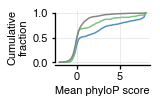

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(1.7,1))
for ds,c in zip(data,colors):
    vs, ts = np.histogram(ds,bins=bins)
    ax.plot(xs, vs.cumsum()/vs.sum(), color=c, zorder=2)
ax.spines['left'].set_bounds(0,1)
ax.set_yticks([0,.5,1])
ax.set_xlabel('Mean phyloP score')
ax.set_ylabel('Cumulative\nfraction')
ax.grid(ls='-',lw=.5)
#fig.savefig(resultpath+'210112_f7c_phylop.pdf')#,dpi=300)

In [24]:
exptbl = pd.read_table('/casa/bsc/projects/resources/fromHD/\
190509_fromHD_rpm_human-cell_truseq.txt',index_col=0)
exptbl.head(2)

,hela,u2os,143b,a549,h520,sw480,dld2,mcf7,mda_mb_231
hsa-let-7a-2-3p,12.545263,0.583895,21.269240,2.183532,17.478615,0.543691,0.898365,0.000000,13.678274
hsa-let-7a-3p,227.795572,65.104319,90.707052,67.689494,56.805499,56.271974,187.309041,44.519413,77.966159


In [25]:
def get_mature_exp(pri):
    mats = primat[pri]
    matexp = []
    for mat in mats:
        matname = annmat.loc[mat,'Name']
        if matname in exptbl.index:
            matexp.append(np.average(exptbl.loc[matname]))
    if matexp:
        return max(matexp)
    return 0
    #return -999

In [26]:
matexp = { p:get_mature_exp(p) for p in overlap }

In [27]:
mirls = [ [m for m in overlap if m in dcsmirsmp],
          [m for m in overlap if m not in dcsmirsmp and m in dcsmirs],
          [m for m in overlap if m in nodcs and m in nodcsmp] ]
data = [ [matexp[m] for m in ml if matexp[m]>-999] for ml in mirls ]
data = [ [c if c<10000 else 10000 for c in cs] for cs in data ]
bins = np.arange(-20,10021,40)
xs = np.arange(0,10001,40)
colors = '#5291bd #78c679 #848484'.split()

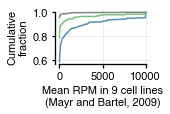

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(1.7,1))
for ds,c in zip(data,colors):
    vs, ts = np.histogram(ds,bins=bins)
    ax.plot(xs, vs.cumsum()/vs.sum(), color=c, zorder=2)
ax.spines['left'].set_bounds(.57,1)
ax.spines['bottom'].set_bounds(0,10000)
ax.set_xlabel('Mean RPM in 9 cell lines\n(Mayr and Bartel, 2009)')
ax.set_ylabel('Cumulative\nfraction')
ax.set_xticks(range(0,10001,5000))
ax.set_yticks([.6,.8,1])
ax.grid(ls='-',lw=.5)
#fig.savefig(resultpath+'210112_f7d__rpm.pdf')#,dpi=300)

## E-H. Nick and inverse processing

In [33]:
## 5p-nick
ps = .0002
ms = [ m for m in overlap if m in s3['5p nick processing'].dropna().index 
       and m in s5['5p nick processing'].dropna().index ]
mssub = [ 'hsa-mir-17','hsa-mir-10b','hsa-mir-20a','hsa-mir-29a','hsa-mir-10a' ]

nick5mp = s3.reindex(ms)['5p nick processing']+ps
nick5sr = s5.reindex(ms)['5p nick processing']+ps

xs = np.log2(nick5sr/nick5mp)
ys = [ effs[m]-effsmp[m] for m in ms ]
xssub = np.log2(nick5sr[mssub]/nick5mp[mssub])
yssub = [ effs[m]-effsmp[m] for m in mssub ]
r, p = spearmanr(xs,ys)

print r, p
print zip(mssub,xssub,yssub)

-0.38615654600417915 6.5787505582657865e-37
[('hsa-mir-17', -8.993868496509595, 1.2745487452397675), ('hsa-mir-10b', -4.482263317932566, 1.508277606953981), ('hsa-mir-20a', -5.590629417281033, 4.445992700095547), ('hsa-mir-29a', -5.459821889334257, 3.0935825087971516), ('hsa-mir-10a', -5.48416014111619, 2.55278880050421)]


Text(-9,-1.6,u'n = 1000\n$R_s$ = -0.39')

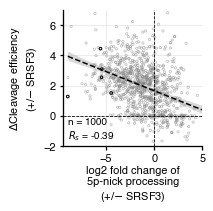

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
sns.regplot(x=xs, y=ys, color='#848484',                            
        scatter_kws={'s':5,'alpha':.5,'zorder':2,'rasterized':True,'facecolor':'None','lw':.8},
        line_kws={'ls':'--','lw':1.5,'color':'k'}, ci=95)
ax.scatter(xssub,yssub,s=7,color='k',zorder=3,rasterized=True, facecolor='None',lw=1)
ax.axhline(0,color='k',ls='--',lw=.8)
ax.axvline(0,color='k',ls='--',lw=.8)

ax.set_xlim(-9.5,5)
ax.set_ylim(-2,7)
ax.set_xlabel('log2 fold change of\n5p-nick processing\n(+/$\minus$ SRSF3)')
ax.set_ylabel('$\Delta$Cleavage efficiency\n(+/$\minus$ SRSF3)')
ax.grid(ls='-',lw=.5)
ax.text(-9,-1.6,'n = %s\n$R_s$ = %.2f'%(len(xs),r))
#fig.savefig(resultpath + '210112_f7f__productive_change_5p.pdf',dpi=300)

In [31]:
## inverse 
ps = .0002
ms = [ m for m in overlap if m in s3['Inverted processing'].dropna().index 
       and m in s5['Inverted processing'].dropna().index ]
mssub = [ 'hsa-mir-142','hsa-let-7c','hsa-mir-30b','hsa-mir-122','hsa-mir-147b' ]

invmp = s3.reindex(ms)['Inverted processing']+ps
invsr = s5.reindex(ms)['Inverted processing']+ps

xs = np.log2(invsr/invmp)
ys = [ effs[m]-effsmp[m] for m in ms ]
xssub = np.log2(invsr[mssub]/invmp[mssub])
yssub = [ effs[m]-effsmp[m] for m in mssub ]
r, p = spearmanr(xs,ys)

print r, p, len(ms)
print zip(mssub,xssub,yssub)

-0.5415862936275108 2.6980507490974354e-77 1000
[('hsa-mir-142', -3.9625412567873095, 3.0111900619582532), ('hsa-let-7c', -6.137476163859865, 4.632083793405517), ('hsa-mir-30b', -5.130769860859959, 1.960535789275288), ('hsa-mir-122', -8.643380201114546, 3.9014745501370616), ('hsa-mir-147b', -9.477369426847744, 4.1844941627531815)]


Text(2,5.7,u'n = 1000\n$R_s$ = -0.54')

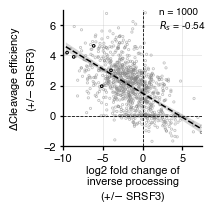

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
sns.regplot(x=xs, y=ys, color='#848484',                            
        scatter_kws={'s':5,'alpha':.5,'zorder':2,'rasterized':True,'facecolor':'None','lw':.8},
        line_kws={'ls':'--','lw':1.5,'color':'k'}, ci=95)
ax.scatter(xssub,yssub,s=7,color='k',zorder=3,rasterized=True, facecolor='None',lw=1)

ax.axhline(0,color='k',ls='--',lw=.8)
ax.axvline(0,color='k',ls='--',lw=.8)
ax.set_xlim(-10,7.5)
ax.set_ylim(-2,7)
ax.set_xlabel('log2 fold change of\ninverse processing\n(+/$\minus$ SRSF3)')
ax.set_ylabel('$\Delta$Cleavage efficiency\n(+/$\minus$ SRSF3)')
ax.grid(ls='-',lw=.5)
ax.text(2,5.7,'n = %s\n$R_s$ = %.2f'%(len(xs),r))
#fig.savefig(resultpath + '210112_f7h__productive_change_inv.pdf',dpi=300)

In [46]:
## 3p-nick
ps = .0002
ms = [ m for m in overlap if m in s3['3p nick processing'].dropna().index 
       and m in s7['3p nick processing'].dropna().index ]
mssub = [ 'hsa-mir-16-2','hsa-mir-128-1','hsa-mir-30c-2' ]

nick3mp = s3.reindex(ms)['3p nick processing']+ps
nick3sr = s7.reindex(ms)['3p nick processing']+ps

xs = np.log2(nick3sr/nick3mp)
ys = [ effs[m]-effsmp[m] for m in ms ]
xssub = np.log2(nick3sr[mssub]/nick3mp[mssub])
yssub = [ effs[m]-effsmp[m] for m in mssub ]
r, p = spearmanr(xs,ys)

print r, p
print zip(mssub,xssub,yssub)

-0.16047731299934895 3.4157717513219187e-07
[('hsa-mir-16-2', -3.82856526884623, 5.920675417495879), ('hsa-mir-128-1', -1.5116823640515122, 8.154447404330554), ('hsa-mir-30c-2', -0.9163805154521716, 5.086594031619381)]


Text(-6.3,-4,u'N = 950\n$R_s$ = -0.18')

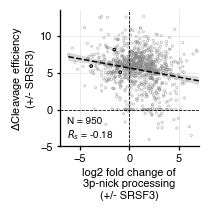

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
sns.regplot(x=xs, y=ys, color='#848484',                            
        scatter_kws={'s':5,'alpha':.5,'zorder':2,'rasterized':True,'facecolor':'None','lw':.8},
        line_kws={'ls':'--','lw':1.5,'color':'k'}, ci=95)
ax.scatter(xssub,yssub,s=7,color='k',zorder=3,rasterized=True, facecolor='None',lw=1)
ax.axhline(0,color='k',ls='--',lw=.8)
ax.axvline(0,color='k',ls='--',lw=.8)

ax.set_xlim(-7,7)
ax.set_ylim(-5,13.5)
ax.set_xlabel('log2 fold change of\n3p-nick processing\n(+/- SRSF3)')
ax.set_ylabel('$\Delta$Cleavage efficiency\n(+/- SRSF3)')
ax.grid(ls='-',lw=.5)
ax.text(-6.3,-4,'N = %s\n$R_s$ = %.2f'%(len(xs),r))
#fig.savefig(resultpath + '201215_s7__productive_change_3p.pdf',dpi=300)

## I. Cleavage site comparison with fCLIP-seq

In [35]:
fclipexcel = pd.ExcelFile('supplementary/Kim_2017_s2.xlsx')
fclip293t = fclipexcel.parse('HEK293T_miRBase', index_col=0)
fcliphela = fclipexcel.parse('HeLa_miRBase', index_col=0)
both293t = fclip293t[(fclip293t['Group5p']!='Unidentified')
                     &(fclip293t['Group3p']!='Unidentified')]
bothhela = fcliphela[(fcliphela['Group5p']!='Unidentified')
                     &(fcliphela['Group3p']!='Unidentified')]
fclip = [ mir for mir in s2.index if mir in both293t.index or mir in bothhela.index ]
print len(fclip)

281


In [36]:
fclsites = {}
for mir in fclip:   
    if mir in both293t.index:
        fcl5cs = map(int, str(both293t.loc[mir, 'fCLIPPosition5p']).split(';'))
    elif mir in bothhela.index:
        fcl5cs = map(int, str(bothhela.loc[mir, 'fCLIPPosition5p']).split(';'))
    else:
        continue
    fclsites[mir] = set(fcl5cs)
print len(fclsites)

281


In [37]:
mpsites = {}
for mir in dcsmirsmp:
    c5, c3 = s3.loc[mir,["5' cleavage site","3' cleavage site"]]
    clv = [c5]
    cs, ce, strand = s2.loc[mir,['Start','End','Strand']]    
    if strand=='+':
        mpsites[mir] = set([int(cs+c-1) for c in clv])
    else:
        mpsites[mir] = set([int(ce-c+1) for c in clv])
print mpsites['hsa-let-7a-1']

set([94175962])


In [39]:
srsites = {}
for mir in dcsmirs:
    c5, c3 = s5.loc[mir,["5' cleavage site","3' cleavage site"]]
    clv = [c5]
    cs, ce, strand = s2.loc[mir,['Start','End','Strand']]
    if strand=='+':
        srsites[mir] = set([int(cs+c-1) for c in clv])
    else:
        srsites[mir] = set([int(ce-c+1) for c in clv])
print srsites['hsa-let-7a-1']

set([94175962])


In [43]:
fclip2 = [m for m in fclip if m in overlap]
print len(fclip2)
mls = [ dcsmirsmp, dcsmirs ]
data = []
for ml,sites in zip(mls,[mpsites,srsites]):
    ys = []
    ys.append(len([m for m in fclip2 if m not in ml]))
    ys.append(len([m for m in fclip2 if m in ml and not(sites[m]<=fclsites[m])]))
    ys.append(len([m for m in fclip2 if m in ml and sites[m]<=fclsites[m]]))
    data.append(ys)
print data

272
[[82, 21, 169], [40, 12, 220]]


In [41]:
ys1 = np.array(data[0])/len(fclip2)
ys2 = np.array(data[1])/len(fclip2)
colors = [ '#ababab','#757575','#242424' ]
print ys1,ys2

[0.30147059 0.07720588 0.62132353] [0.14705882 0.04411765 0.80882353]


(-0.5, 1.5, 0.0, 1.05)

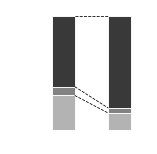

In [42]:
## color version
fig, ax = plt.subplots(1, 1, figsize=(2,2.2))
bottom = np.array([0.,0.])
for y1, y2, color in zip(ys1, ys2, colors):
    ax.bar(range(2), [y1, y2], bottom=bottom, width=.4, linewidth=1, edgecolor='white',
           color=color, zorder=2, alpha=.9)
    bottom += np.array([y1,y2])
    l = lines.Line2D([.2,.8], bottom, linewidth=.8, color='black', linestyle='--')
    l.set_clip_on(False)
    ax.add_line(l)

ax.set_xlim(-.5, 1.5)
ax.set_xticks([0,1])
ax.tick_params(bottom='off')
ax.axis('off')
#fig.savefig(resultpath + '210112_f7i__fclip.pdf')

## J. SRSF3 responsive element

In [44]:
def find_cnnc(mir, cnnc):
    if mir in dcsmirs:
        pe = majorcs[mir][1]
    else:
        pe = preposition[mir][1]
    cnncseq = constseqs[mir][pe+14:pe+22]
    return bool(re.search(cnnc, cnncseq))

In [45]:
rescue = [m for m in overlap if m in dcsmirs and m in nodcsmp]
print len(rescue)

201


In [47]:
rescnnc = [ m for m in rescue if find_cnnc(m,'C..C') ]
rescnnd = [ m for m in rescue if find_cnnc(m,'C..[^C]|[^C]..C') and m not in rescnnc ]
rest = [ m for m in rescue if m not in rescnnc+rescnnd ]
print len(rescnnc), len(rescnnd), len(rest)

140 47 14


In [48]:
mirls = [ rescnnc, rescnnd, rest ]
yse = [[ effs[m]-effsmp[m] for m in ml ] for ml in mirls]
ysh = [[ homs[m]-homsmp[m] for m in ml ] for ml in mirls]

cs = [ '#ababab','#6baed6','#9e9ac8','#fd8d3c' ]
labels = [ 'CNNC\n(%s)'%len(mirls[0]),'CNND\nor DNNC\n(%s)'%len(mirls[1]),
           'Rest\n(%s)'%len(mirls[2])]

In [49]:
print mannwhitneyu(yse[0],yse[1],alternative='greater')[1]
print mannwhitneyu(yse[1],yse[2],alternative='greater')[1]
print mannwhitneyu(ysh[0],ysh[1],alternative='greater')[1]
print mannwhitneyu(ysh[1],ysh[2],alternative='greater')[1]

0.04584570699707166
0.6048198864710412
0.0009759845838598174
0.04085563841014155


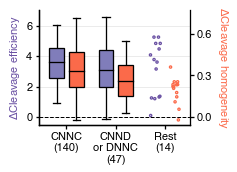

In [50]:
fig, ax1 = plt.subplots(1, 1, figsize=(2.7,2.1)); ax2 = ax1.twinx()
for ax,c,ys,off in zip([ax1,ax2],['#807dba','#fb6a4a'],[yse,ysh],[-.2,.2]):
    bp = ax.boxplot(ys[:2], widths=.3, sym='', boxprops={'linewidth':1.3}, patch_artist=True,
                capprops={'linewidth':1.3}, medianprops={'linewidth':1.3,'color':'k'},
                whiskerprops={'linewidth':1.3}, positions=np.arange(1,3)+off, whis=1,zorder=2)
    for box in bp['boxes']:
        box.set_facecolor(c)
        box.set_zorder(2)

xs1 = np.random.uniform(2.7,2.9,len(yse[2]))
ax1.scatter(np.array(xs1), sorted(yse[2]),s=5,edgecolor='#6a51a3',facecolor='None',lw=1.3,
           zorder=2)
xs2 = np.random.uniform(3.1,3.3,len(yse[2]))
ax2.scatter(np.array(xs2), sorted(ysh[2]),s=5,edgecolor='#fb6a4a',facecolor='None',lw=1.3,
           zorder=2)
ax1.axhline(0,color='k',lw=1,ls='--',zorder=3)

ax1.set_ylabel('$\Delta$Cleavage efficiency', color='#6a51a3')
fig.text(1.07,.5,'$\Delta$Cleavage homogeneity',rotation=270,va='center',
        ha='center',fontsize=11,color='#fb6a4a')
ax1.set_xticks(range(1,1+len(mirls)))
ax1.set_xticklabels(labels)
ax1.set_xlim(.45,3.5)
ax1.set_ylim(-.5,7)
ax2.set_ylim(-.055,.77)
ax2.set_yticks([0,.3,.6])
ax2.spines['right'].set_visible(True)
ax1.yaxis.grid(ls='-',lw=.5)
#fig.savefig(resultpath + '210112_f7j__cnnc.pdf')

## Suppl 6A. Cleavage homogeneity

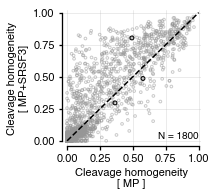

In [226]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
xs = [ homsmp[m] for m in overlap ]
ys = [ homs[m] for m in overlap ]
sub = ['hsa-mir-142','hsa-mir-101-2','hsa-let-7d']
xssub = [ homsmp[m] for m in sub ]
yssub = [ homs[m] for m in sub ]

ax.scatter(xs,ys,s=7,color='#969696',zorder=2,rasterized=True,alpha=.5,facecolor='None',lw=1)
ax.scatter(xssub,yssub,s=15,color='k',zorder=2,rasterized=True,facecolor='None',lw=1)
ax.set_xticks(np.arange(0,1.1,.25)); ax.set_xticks(np.arange(0,1.1,.25))
ax.set_xlabel('Cleavage homogeneity\n[ MP ]')
ax.set_ylabel('Cleavage homogeneity\n[ MP+SRSF3]')
ax.grid(ls='-',lw=.5)
ax.spines['bottom'].set_bounds(0,1)
ax.spines['left'].set_bounds(0,1)
ax.plot([0,1],[0,1],'k--')
ax.set_xlim(-.04,1.02)
ax.set_ylim(-.04,1.02)
ax.set_yticks(np.arange(0,1.1,.25))
ax.text(1,.02,'N = %s'%len(xs),ha='right')
fig.savefig(resultpath + '210112_s6a__homogeneity.pdf',dpi=300)

## Discussion

#### Relaxed cutoffs

In [52]:
REL_ECUT = .75
REL_HCUT = .1

In [55]:
mirls = [ [m for m in overlap if m in drodep], 
          [m for m in overlap if m in droind],
          [m for m in overlap if m not in list(drodep)+list(droind)] ]
xsl = [ [effs[m] for m in ml] for ml in mirls ]
ysl = [ [homs[m] for m in ml] for ml in mirls ]
fcolors = [ '#1b9e77', '#666666', '#cbcbcb' ]
ecolors = [ '#018571', '#353535','#bababa' ]
labels = [ 'DRO-dep.', 'DRO-ind.', 'Not yet determined' ]
sizes = [ 10, 10, 6 ]
zs = [ 4, 3, 2 ]
xmin, xmax, xo = 0, 7, .15
ymin, ymax, yo = 0, 1, .03
xcut, ycut = REL_ECUT, REL_HCUT
shade = '#a1d99b'
print map(len,mirls)

[302, 254, 1244]


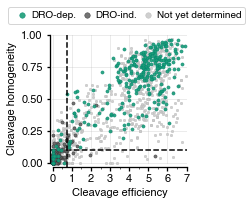

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
for xs,ys,fc,ec,label,s,z in zip(xsl,ysl,fcolors,ecolors,labels,sizes,zs):
    xs,ys = zip(*[ (x,y) for x,y in zip(xs,ys) if xmin<=x<xmax and ymin<=y<ymax])
    ax.scatter(xs, ys, s=s, color=fc, edgecolor=ec, lw=.5, zorder=z, label=label, alpha=.9,
              rasterized=True)
ax.plot([xmin-xo,xmax],[ycut,ycut],'k--',zorder=2)
ax.plot([xcut,xcut],[ymin-yo,ymax],'k--',zorder=4)

ax.set_xlabel('Cleavage efficiency',fontsize=11)
ax.set_ylabel('Cleavage homogeneity',fontsize=11)
ax.set_xticks(range(xmin,xmax+1))
ax.set_xticks(np.arange(xmin,xmax+xo,.5),minor=True)
ax.set_yticks(np.arange(ymin,ymax+yo,.25))
ax.set_xlim(xmin-xo, xmax+xo)
ax.set_ylim(ymin-yo, ymax+yo)
ax.spines['bottom'].set_bounds(xmin, xmax)
ax.spines['left'].set_bounds(ymin, ymax)
leg = ax.legend(loc=(-.3,1.05), handletextpad=-.1, ncol=3, columnspacing=.05)
for handle in leg.legendHandles:
    handle.set_sizes([30])

gr = plt.Rectangle((xmin-xo/4,ymin-yo/4), xmax+xo/4, ymax+yo/4, fc='w'); ax.add_patch(gr)
ax.grid(ls='-', lw=.5, clip_path=gr)
#fig.savefig(resultpath + '210118_cleavage_pattern_srsf3.pdf',dpi=300)

#### Conservation across mammals

In [66]:
excel = pd.ExcelFile('supplementary/Fang_2015_s3.xlsx')
fangtbl = excel.parse('Human',header=2,index_col=0)

In [67]:
mirfams = {}
mid = ''
for l in open('/casa/bsc/databases/miRNA/miFam.dat','rt'):
    if l.startswith('ID'):
        mid = l.split()[1]
        mirfams[mid] = []
    elif l.startswith('MI') and 'hsa' in l and mid:
        mirfams[mid].append(l.split()[2])

In [68]:
mamcons = []
for fam in fangtbl['Family'].tolist():
    if fam in mirfams:
        mamcons = mamcons+mirfams[fam]
print len(set(mamcons))

366


In [69]:
def get_conserved(mirl):
    return [m for m in mamcons if m in mirl]

#### ERH/SAFB-dependence

In [51]:
erh = pd.ExcelFile('supplementary/Kwon_2020_s1.xlsx')
erhtbl = erh.parse('Merged',index_col=0,header=6)

ERHCUT, SAFBCUT = 400, 50
FCCUT = -.5

def is_dependent(mir, s, rcut, fcut):
    return (mir in erhtbl[(erhtbl['baseMean_%s'%s]>=rcut)&(erhtbl['log2FC_%s'%s]<=fcut)].index)

def is_sufficient(mir, s, rcut, fcut):
    return (mir in erhtbl[(erhtbl['baseMean_%s'%s]>=rcut)].index)

def get_suffs(mirl):
    return [ m for m in mirl if is_sufficient(m,'siERH',ERHCUT,FCCUT) or
                                is_sufficient(m,'SAFB_DKO_293T',SAFBCUT,FCCUT) or 
                                is_sufficient(m,'SAFB_DKO_Ramos',SAFBCUT,FCCUT) ]
def get_depends(mirl):
    return [ m for m in mirl if is_dependent(m,'siERH',ERHCUT,FCCUT) or
                                is_dependent(m,'SAFB_DKO_293T',SAFBCUT,FCCUT) or 
                                is_dependent(m,'SAFB_DKO_Ramos',SAFBCUT,FCCUT) ]

#### Classification - stringent cutoffs

In [70]:
productive = [ m for m in overlap if m in dcsmirs or m in dcsmirsmp ]
failed = [ m for m in overlap if m not in productive ]
print len(productive), len(failed)

758 1042


In [73]:
Counter(s1.reindex(failed)['DROSHA dependency'])

Counter({'DROSHA-dependent, verified by DROSHA KO': 2,
         'DROSHA-dependent, verified by DROSHA KO, fCLIP-seq': 8,
         'DROSHA-dependent, verified by fCLIP-seq': 31,
         'DROSHA-independent, Capped miRNA': 11,
         'DROSHA-independent, Mirtron': 234,
         'DROSHA-independent, SnoRNA-derived miRNA': 6,
         'DROSHA-independent, tRNA-related miRNA': 1,
         'Not yet determined': 749})

In [79]:
faildep = [ m for m in failed if m in drodep ]
print len(faildep)
print len(get_suffs(faildep)), len(faildep)-len(get_suffs(faildep))
print len(get_depends(faildep))

41
26 15
19


In [82]:
failunk = [ m for m in failed if s1.loc[m,'DROSHA dependency']=='Not yet determined']
print len(failunk)
print len([m for m in failunk if m in dbmirs]), len(get_conserved(failunk))

749
29 27


#### Classification - relaxed cutoffs

In [74]:
dcsmirsmpr = [ m for m in overlap if effsmp[m]>=REL_ECUT and homsmp[m]>=REL_HCUT ] 
dcsmirsr = [ m for m in overlap if effs[m]>=REL_ECUT and homs[m]>=REL_HCUT ] 
productiver = [ m for m in overlap if m in dcsmirsr or m in dcsmirsmpr ]
failedr = [ m for m in overlap if m not in productiver ]
print len(productiver), len(failedr)

907 893


In [75]:
Counter(s1.reindex(failedr)['DROSHA dependency'])

Counter({'DROSHA-dependent, verified by DROSHA KO': 1,
         'DROSHA-dependent, verified by DROSHA KO, fCLIP-seq': 5,
         'DROSHA-dependent, verified by fCLIP-seq': 16,
         'DROSHA-independent, Capped miRNA': 9,
         'DROSHA-independent, Mirtron': 213,
         'DROSHA-independent, SnoRNA-derived miRNA': 5,
         'DROSHA-independent, tRNA-related miRNA': 1,
         'Not yet determined': 643})

In [80]:
failrdep = [ m for m in failedr if m in drodep ]
print len(failrdep)
print len(get_suffs(failrdep)), len(failrdep)-len(get_suffs(failrdep))
print len(get_depends(failrdep))

22
12 10
11


In [83]:
failrunk = [ m for m in failedr if s1.loc[m,'DROSHA dependency']=='Not yet determined']
print len(failrunk)
print len([m for m in failrunk if m in dbmirs]), len(get_conserved(failrunk))

643
16 20


#### Mirtrons

In [57]:
mirtrons = s1[s1['DROSHA dependency'].apply(lambda x:x.find('Mirtron')>=0)].index
mirls = [ [m for m in overlap if m in mirtrons], 
          [m for m in overlap if m not in mirtrons] ]
xsl = [ [effs[m] for m in ml] for ml in mirls ]
ysl = [ [homs[m] for m in ml] for ml in mirls ]
fcolors = [ '#dfc27d', '#cbcbcb' ]
ecolors = [ '#a6611a','#bababa' ]
labels = [ 'Mirtrons (%s)'%len(mirls[0]), 'The rest (%s)'%len(mirls[1]) ]
sizes = [ 12, 5 ]
zs = [ 3,2 ]
xmin, xmax, xo = 0, 8, .15
ymin, ymax, yo = 0, 1, .03
xcut, ycut = 1.5, .25
shade = '#a1d99b'
print map(len,mirls)

[236, 1564]


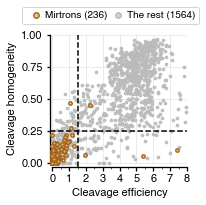

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
for xs,ys,fc,ec,label,s,z in zip(xsl,ysl,fcolors,ecolors,labels,sizes,zs):
    xs,ys = zip(*[ (x,y) for x,y in zip(xs,ys) if xmin<=x<xmax and ymin<=y<ymax])
    ax.scatter(xs, ys, s=s, color=fc, edgecolor=ec, lw=1.5, zorder=z, label=label, alpha=.9,
              rasterized=True)
ax.plot([xmin-xo,xmax],[ycut,ycut],'k--',zorder=2)
ax.plot([xcut,xcut],[ymin-yo,ymax],'k--',zorder=2)

ax.set_xlabel('Cleavage efficiency',fontsize=11)
ax.set_ylabel('Cleavage homogeneity',fontsize=11)
ax.set_xticks(range(xmin,xmax+1))
ax.set_xticks(np.arange(xmin,xmax+xo,.5),minor=True)
ax.set_yticks(np.arange(ymin,ymax+yo,.25))
ax.set_xlim(xmin-xo, xmax+xo)
ax.set_ylim(ymin-yo, ymax+yo)
ax.spines['bottom'].set_bounds(xmin, xmax)
ax.spines['left'].set_bounds(ymin, ymax)
leg = ax.legend(loc=(-.2,1.05), handletextpad=-.1, ncol=3, columnspacing=.05)
for handle in leg.legendHandles:
    handle.set_sizes([30])

gr = plt.Rectangle((xmin-xo/4,ymin-yo/4), xmax+xo/4, ymax+yo/4, fc='w'); ax.add_patch(gr)
ax.grid(ls='-', lw=.5, clip_path=gr)
#fig.savefig(resultpath + '210114_cleavage_pattern_srsf3.pdf',dpi=300)

#### miRBase v22

In [60]:
# miBRase v22 gff file
gff = 'supplementary/human_mirbase-v22.gff3'
anntbl = pd.read_table(gff, header=12, sep='\t', usecols=[0,2,3,4,6,8], 
                       names=['chr','kind','start','end','strand','attr'])
anntbl = anntbl.apply(parse_line, axis=1).drop(['attr'], axis=1)
anntbl.head(3)

,Alias,Derives_from,ID,Name,chr,end,kind,start,strand
0,MI0022705,NaN,MI0022705,hsa-mir-6859-1,chr1,17436,miRNA_primary_transcript,17369,-
1,MIMAT0027618,MI0022705,MIMAT0027618,hsa-miR-6859-5p,chr1,17431,miRNA,17409,-
2,MIMAT0027619,MI0022705,MIMAT0027619,hsa-miR-6859-3p,chr1,17391,miRNA,17369,-


In [61]:
annpri = anntbl[anntbl['kind']=='miRNA_primary_transcript'].set_index('Name')
annmat = anntbl[anntbl['kind']=='miRNA'].set_index('ID')
all22 = sorted(list(set(annpri.index)))
print len(all22)

1913


In [64]:
added = [ m for m in all22 if m not in s1.index ]
dropd = [ m for m in s1.index if m not in all22 ]
print len(added), len(dropd)
print len([m for m in dropd if m in overlap])
print [m for m in dropd if m in overlap and m in dcsmirs+dcsmirsmp]

63 31
28
['hsa-mir-3591']


#### Alternative processing

In [85]:
altmp = [m for m in dcsmirsmp if s3.loc[m,'Cleavage ratio of alternative site']>=HOMCUT]
alt = [m for m in dcsmirs if s5.loc[m,'Cleavage ratio of alternative site']>=HOMCUT]
print len(altmp), len(alt)
print len([m for m in productive if m in altmp or m in alt])

44 57
85


#### Change by SRSF3

In [86]:
nulleffs = [effs[m]-effsmp[m] for m in overlap if m in droind]
nullhoms = [abs(homs[m]-homsmp[m]) for m in overlap if m in droind]
ecut = np.percentile(nulleffs,99)
hcut = np.percentile(nullhoms,99)
print hcut,ecut

0.1848244912905954 0.9352973498839969


In [87]:
ovdep = [ m for m in overlap if m in drodep ]
print len(ovdep)
print len([m for m in ovdep if effs[m]-effsmp[m]>ecut or abs(homs[m]-homsmp[m])>hcut])

302
253
